In [65]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

In [66]:
df = pd.read_csv('../../../traces/workload_traces/workloads.csv')
df = df[df['platform'] == 'platform-0']
df.head()

,dataset,family,algorithm,platform,run,duration,schedulerDelay,executorRunTime,executorCpuTime,executorDeserializeTime,...,peakExecutionMemory,bytesRead,shuffleFetchWaitTime,shuffleTotalBytesRead,shuffleTotalBlocksFetched,shuffleLocalBlocksFetched,shuffleRemoteBlocksFetched,shuffleWriteTime,shuffleBytesWritten,fitTime
25,DHG,clustering,BKM,platform-0,0,17659195,128151,17384950,11387091,145831,...,167220911,184898948086,11,4147111,6880,172,6708,1225,4147111,154268.0
86,DHG,clustering,KM,platform-0,0,2460043,166627,2144081,1271561,148948,...,166841115,93470581548,17,3325656,8000,200,7800,1557,3325656,23986.0
147,DHG,clustering,GMM,platform-0,0,3978738,65534,3811085,2722073,101836,...,187344416,71467580940,65,22957409,3360,88,3272,1382,22957409,41089.0
208,DHG,classification,MLP,platform-0,0,28939205,230008,28464293,27159748,244315,...,11525196032,222962779362,1087,439793063,18080,442,17638,426,439793063,201822.0
269,DHG,classification,DT,platform-0,0,4076430,84125,3890030,2411518,101949,...,46499059786,48354541616,16113,483366273,96480,2412,94068,2941,483366273,37718.0


In [67]:
features = list(df.columns)[5:]
x = df.loc[:, features]
x = StandardScaler().fit_transform(x.values)

In [68]:
pca = PCA(n_components=len(features))
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component {}'.format(i) for i in range(1, len(features) + 1)])
principalDf = principalDf[['principal component 1', 'principal component 2','principal component 3']]
principalDf.head()

,principal component 1,principal component 2,principal component 3
0,2.111429,5.912861,0.192742
1,0.431700,0.856524,-0.682873
2,0.211031,1.580474,-0.463497
3,4.641006,10.167280,0.986056
4,1.779200,0.650239,-0.837242


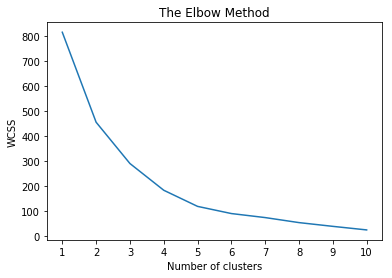

In [69]:
#Using the elbow method to find the optimal number of clusters 
from sklearn.cluster import KMeans

wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(principalComponents)
    wcss.append (kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.xticks(range(1,11))
plt.ylabel('WCSS')
plt.show()

In [70]:
# Applying k-means to the dataset
kmeans = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans.fit(principalComponents)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [71]:
kmeans.labels_

array([0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [72]:
principalDf['cluster'] = kmeans.labels_

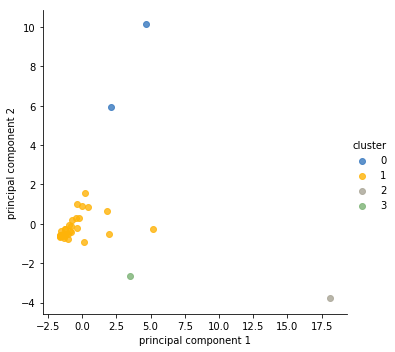

In [73]:
colors = ["windows blue", "amber", "greyish", "faded green"]
sns.lmplot(x='principal component 1', y='principal component 2', data=principalDf, hue='cluster', palette=sns.xkcd_palette(colors), fit_reg=False)

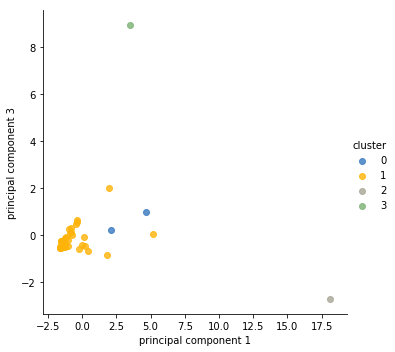

In [74]:
sns.lmplot(x='principal component 1', y='principal component 3', data=principalDf, hue='cluster', palette=sns.xkcd_palette(colors), fit_reg=False)

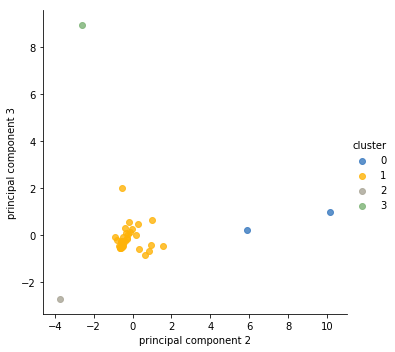

In [75]:
sns.lmplot(x='principal component 2', y='principal component 3', data=principalDf, hue='cluster', palette=sns.xkcd_palette(colors), fit_reg=False)

# Removing outliers

In [76]:
labels = list(df.dataset + df.algorithm)
principalDf['workload'] = labels
principalDf = principalDf[principalDf.cluster == 1]

In [77]:
principalDf.head()

,principal component 1,principal component 2,principal component 3,cluster,workload
1,0.431700,0.856524,-0.682873,1,DHGKM
2,0.211031,1.580474,-0.463497,1,DHGGMM
4,1.779200,0.650239,-0.837242,1,DHGDT
5,-0.238699,0.304503,-0.612174,1,DHGBLR
7,5.185982,-0.239401,0.043406,1,DHGRFR


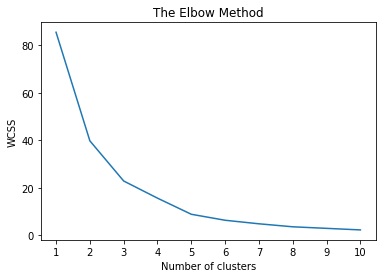

In [78]:
#Using the elbow method to find the optimal number of clusters 
from sklearn.cluster import KMeans

wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(principalDf.values[:, :-1])
    wcss.append (kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.xticks(range(1,11))
plt.ylabel('WCSS')
plt.show()

In [79]:
# Applying k-means to the dataset
kmeans = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans.fit(principalDf.values[:, :-1])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [80]:
kmeans.labels_

array([4, 4, 4, 0, 1, 4, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 3, 0, 0, 2, 0, 0, 0, 3, 0, 3, 3, 0, 3, 3], dtype=int32)

In [81]:
principalDf['cluster'] = kmeans.labels_

In [82]:
principalDf.head()

,principal component 1,principal component 2,principal component 3,cluster,workload
1,0.431700,0.856524,-0.682873,4,DHGKM
2,0.211031,1.580474,-0.463497,4,DHGGMM
4,1.779200,0.650239,-0.837242,4,DHGDT
5,-0.238699,0.304503,-0.612174,0,DHGBLR
7,5.185982,-0.239401,0.043406,1,DHGRFR


/home/yacineg/.local/lib/python3.5/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


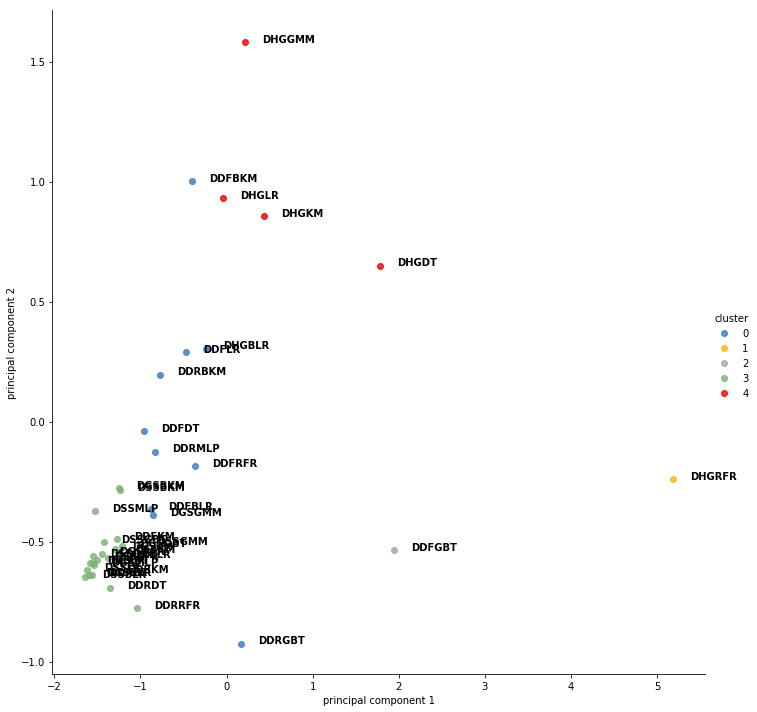

In [106]:
outlier_colors = ["windows blue", "amber", "greyish", "faded green", "red"]

pl = sns.lmplot(x='principal component 1', y='principal component 2', data=principalDf, hue='cluster', palette=sns.xkcd_palette(outlier_colors), fit_reg=False, size=10)


for line in principalDf.index:
    plt.gca().text(principalDf['principal component 1'][line]+0.2, principalDf['principal component 2'][line], principalDf['workload'][line], horizontalalignment='left', size='medium', color='black', weight='semibold')
 

/home/yacineg/.local/lib/python3.5/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


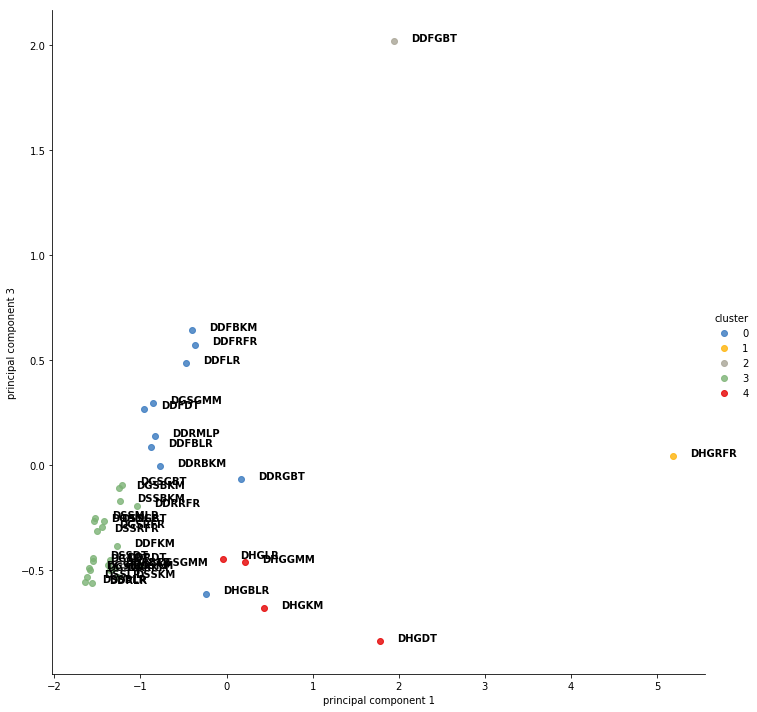

In [108]:
pl = sns.lmplot(x='principal component 1', y='principal component 3', data=principalDf, hue='cluster', palette=sns.xkcd_palette(outlier_colors), fit_reg=False, size=10)


for line in principalDf.index:
    plt.gca().text(principalDf['principal component 1'][line]+0.2, principalDf['principal component 3'][line], principalDf['workload'][line], horizontalalignment='left', size='medium', color='black', weight='semibold')
 

/home/yacineg/.local/lib/python3.5/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


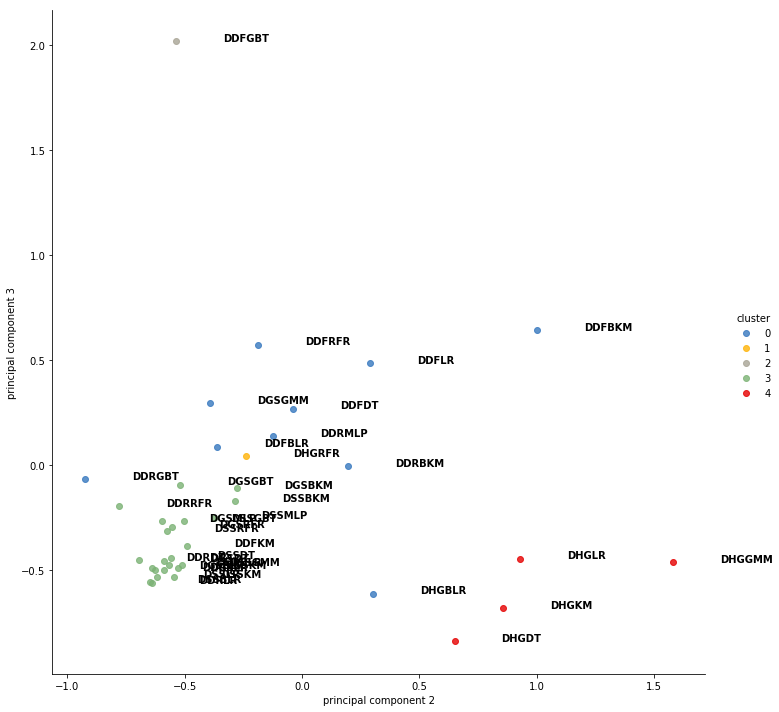

In [109]:
pl = sns.lmplot(x='principal component 2', y='principal component 3', data=principalDf, hue='cluster', palette=sns.xkcd_palette(outlier_colors), fit_reg=False, size=10)


for line in principalDf.index:
    plt.gca().text(principalDf['principal component 2'][line]+0.2, principalDf['principal component 3'][line], principalDf['workload'][line], horizontalalignment='left', size='medium', color='black', weight='semibold')
 

MAIN RULE:
Always the clustering is based first on the dataset used rather than on the algorithm